Provo a fare edge detection con Canny Edge Detection e Blob Detection di OpenCV

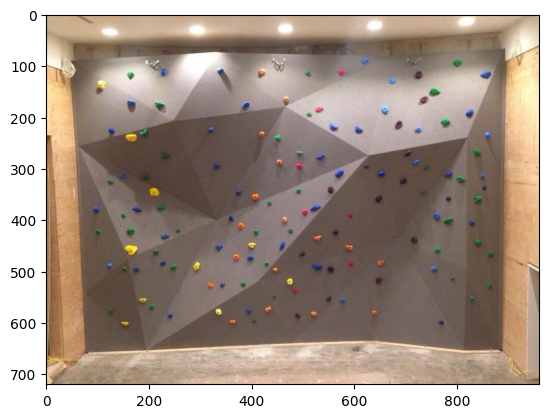

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Read the image from file
image = cv2.imread('climbing_wall.jpg')

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

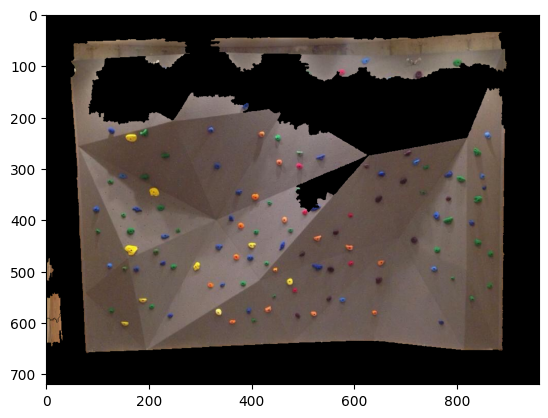

In [2]:
#Ho provato ad osare watershed per fare detection della parete, ma la luce rompe il cazzo. 
#C'è da provare a fare un po' di preprocessing per migliorare la situazione

#try to do watershed segmentation detecting the wall
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(6, 6))
enhanced_gray = clahe.apply(gray)
blurred = cv2.bilateralFilter(gray, 9, 25, 25)

_, binary = cv2.threshold(blurred, 2, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=5)
closed = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=4)

sure_bg = cv2.dilate(closed, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.09 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(image, markers)

mask = np.zeros_like(gray)
mask[markers > 1] = 255

segmented_wall = cv2.bitwise_and(image, image, mask=mask)

plt.imshow(cv2.cvtColor(segmented_wall, cv2.COLOR_BGR2RGB))
plt.show()

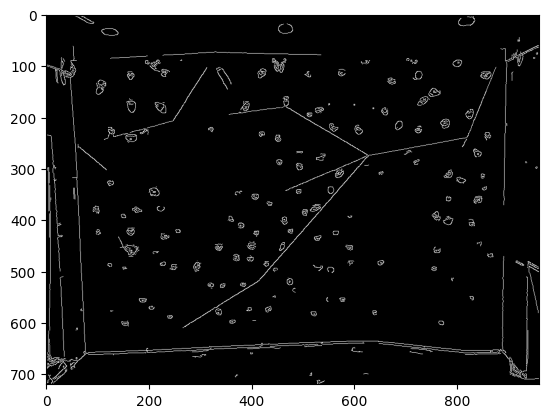

In [3]:

edges = cv2.Canny(image, 100, 200)
plt.imshow(edges, cmap='gray')
plt.show()

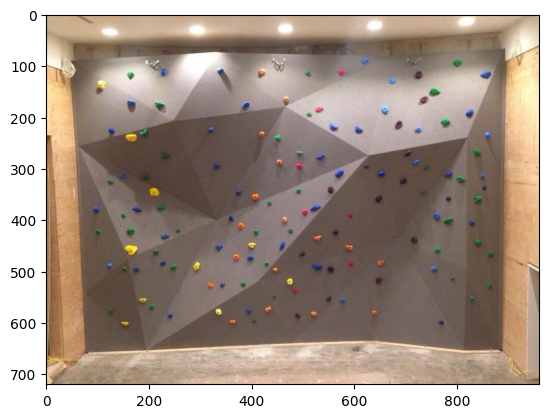

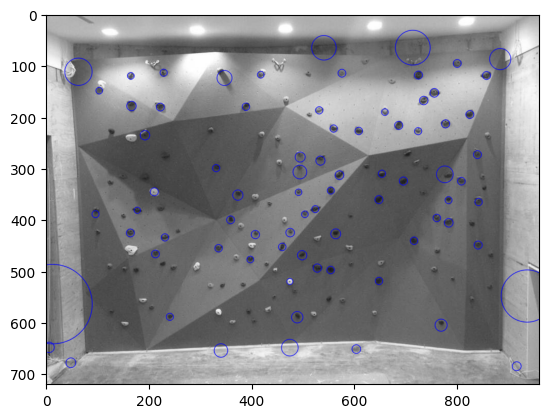

In [4]:

#image in grayscale
image_grey = cv2.imread('climbing_wall.jpg', cv2.IMREAD_GRAYSCALE)

params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 100
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(image_grey)

img_with_keypoints = cv2.drawKeypoints(image_grey, keypoints, np.array([]), (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#show the original image and the image with keypoints
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(img_with_keypoints)
plt.show()

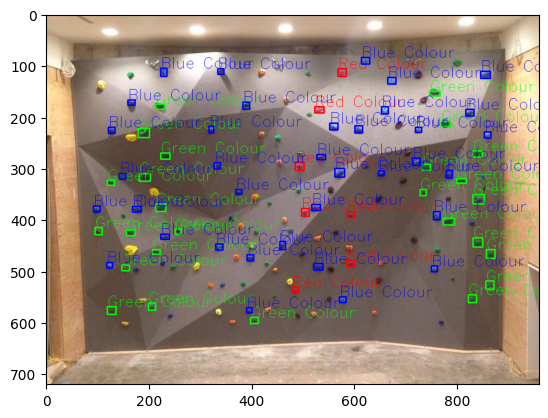

In [5]:
#Ora provo a fare color range analysis per gli holds

hsvFrame = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Set range for red color 
red_lower = np.array([136, 87, 111], np.uint8)
red_upper = np.array([180, 255, 255], np.uint8)

# define mask
red_mask = cv2.inRange(hsvFrame, red_lower, red_upper)

#green color
#rgb(43 115 62)
green_lower = np.array([25, 52, 30], np.uint8)
green_upper = np.array([102, 150, 100], np.uint8)
green_mask = cv2.inRange(hsvFrame, green_lower, green_upper)

#blue color
blue_lower = np.array([94, 80, 2], np.uint8)
blue_upper = np.array([120, 255, 255], np.uint8)
blue_mask = cv2.inRange(hsvFrame, blue_lower, blue_upper)


# to detect only that particular color
kernal = np.ones((3, 3), "uint8")

# red color
red_mask = cv2.dilate(red_mask, kernal)
res_red = cv2.bitwise_and(image, image, mask=red_mask)

# green color
green_mask = cv2.dilate(green_mask, kernal)
res_green = cv2.bitwise_and(image, image, mask=green_mask)

# blue color
blue_mask = cv2.dilate(blue_mask, kernal)
res_blue = cv2.bitwise_and(image, image, mask=blue_mask)

# Creating contour to track red color
contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for pic, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    image_with_labels = image
    if (area > 70):
        x, y, w, h = cv2.boundingRect(contour)
        image_with_labels = cv2.rectangle(image, (x, y),
                                    (x + w, y + h),
                                    (0, 0, 255), 2)

        cv2.putText(image, "Red Colour", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (0, 0, 255))

# Creating contour to track green color
contours, hierarchy = cv2.findContours(green_mask,
                                        cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)

for pic, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if (area > 70):
        x, y, w, h = cv2.boundingRect(contour)
        image_with_labels = cv2.rectangle(image, (x, y),
                                    (x + w, y + h),
                                    (0, 255, 0), 2)

        cv2.putText(image, "Green Colour", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, (0, 255, 0))

# Creating contour to track blue color
contours, hierarchy = cv2.findContours(blue_mask,
                                        cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_SIMPLE)
for pic, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if (area > 70):
        x, y, w, h = cv2.boundingRect(contour)
        image_with_labels = cv2.rectangle(image, (x, y),
                                    (x + w, y + h),
                                    (255, 0, 0), 2)

        cv2.putText(image, "Blue Colour", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.0, (255, 0, 0))


# final run
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))